# Notebook Description
This notebook shows the experiment of using data from the mixed scenario, with non-shared weights, and the CNN model.

In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random

from keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# Set options and load file
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%load_ext google.colab.data_table
from google.colab import data_table
from google.colab import drive

drive.mount('/content/drive')
os.chdir("YOUR FOLDER HERE")
raw_data_folder = './data/raw/'
interim_data_folder = './data/interim/'
processed_data_folder = './data/processed/'
models_folder = './models/'

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import keras
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.layers import Dot, LSTM, Bidirectional, Reshape,Flatten
from keras.layers.core import Dense
from keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, Conv1D

!pip install keras_nlp
from keras_nlp.layers import PositionEmbedding


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 19.1 MB/s 
     |████████████████████████████████| 5.9 MB 51.9 MB/s 
     |████████████████████████████████| 578.1 MB 26 kB/s 
     |████████████████████████████████| 578.0 MB 18 kB/s 
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
     |████████████████████████████████| 4.6 MB 60.0 MB/s 


In [ ]:
# Load Data
# -------------
alphabet = 'eainlrsotdychmbugkjpfvzwxq.ó'
print('Alphabet:')
print(alphabet)

# Original dfs
train_df = pd.read_csv(interim_data_folder + 'train_df_mixed_shuffled.csv', index_col=0)
validation_df = pd.read_csv(interim_data_folder + 'validation_df_mixed_shuffled.csv', index_col=0)
test_df = pd.read_csv(interim_data_folder + 'test_df_mixed_shuffled.csv', index_col=0)

# tokenized dfs
train_data_names = np.loadtxt(processed_data_folder + 'train_mixed_data_names.txt', dtype = int)
train_data_nicknames = np.loadtxt(processed_data_folder + 'train_mixed_data_nicknames.txt', dtype = int)
validation_data_names = np.loadtxt(processed_data_folder + 'validation_mixed_data_names.txt', dtype = int)
validation_data_nicknames = np.loadtxt(processed_data_folder + 'validation_mixed_data_nicknames.txt', dtype = int)
test_data_names = np.loadtxt(processed_data_folder + 'test_mixed_data_names.txt', dtype = int)
test_data_nicknames = np.loadtxt(processed_data_folder + 'test_mixed_data_nicknames.txt', dtype = int)

# targets
train_targets = np.loadtxt(processed_data_folder + 'train_mixed_targets.txt', dtype = int)
validation_targets = np.loadtxt(processed_data_folder + 'validation_mixed_targets.txt', dtype = int)
test_targets = np.loadtxt(processed_data_folder + 'test_mixed_targets.txt', dtype = int)

print(train_df['name'].tolist()[1])

train_df.iloc[:5]

Alphabet:
eainlrsotdychmbugkjpfvzwxq.ó
flora


,name,nickname,y
4918,theodore,cy,0
4225,flora,belle,0
6871,isabella,bel,1
1136,jo,ara,0
1754,clement,jessie,0


In [ ]:
# print((train_df['y'].values == train_targets))
print(train_df.iloc[:5])
print(train_data_names[:5],'\n')
print(train_data_nicknames[:5])


          name nickname  y
4918  theodore       cy  0
4225     flora    belle  0
6871  isabella      bel  1
1136        jo      ara  0
1754   clement   jessie  0
[[ 9 13  1  8 10  8  6  1  0  0  0  0  0  0  0]
 [21  5  8  6  2  0  0  0  0  0  0  0  0  0  0]
 [ 3  7  2 15  1  5  5  2  0  0  0  0  0  0  0]
 [19  8  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [12  5  1 14  1  4  9  0  0  0  0  0  0  0  0]] 

[[12 11  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [15  1  5  5  1  0  0  0  0  0  0  0  0  0  0]
 [15  1  5  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  6  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [19  1  7  7  3  1  0  0  0  0  0  0  0  0  0]]


In [ ]:
# Define Loss
def cosine_loss(y_true, y_pred, m=0.4, alpha = 0.25):
  # IT IS IMPORTANT TO NOTE THAT IN KERAS CUSTOM LOSS FUNCTIONS, THE ORDER
  # DOES MATTER - KERAS ASSUMES THAT THE FIRST ELEMENT IS y AND THAT THE SECOND
  # IS y_hat.

  y_true=tf.cast(y_true, tf.float32)
  y_pred=tf.cast(y_pred, tf.float32)

  # Create the mask - wherever y_pred<m. Recall that this condition takes place 
  # only for L_ and if E>=m then L_==0. 
  # mask = K.less(y_pred,m)
  mask = K.greater(y_pred,m)
  
  mask = tf.cast(mask,tf.float32)
  mask = mask * (1-y_true)*K.square(y_pred)
  # print(mask)
  L = y_true*alpha*tf.square(1 - y_pred) + mask
  return K.mean(L)



# BCSloss

In [ ]:
tf.random.set_seed(
    2
)

# Define inputs
left_input = Input((15,))
right_input = Input((15,))

embedded_l = Embedding(15, 35)(left_input)
embedded_r = Embedding(15, 35)(right_input)

position_embeddings_l = PositionEmbedding(
    sequence_length=15)(embedded_l)
position_embeddings_r = PositionEmbedding(
    sequence_length=15)(embedded_r)

embedded_l = embedded_l + position_embeddings_l
embedded_r = embedded_r + position_embeddings_r


C_l = tf.keras.layers.Conv1D(filters = 32,
                            kernel_size = 2,
                            padding = 'same',
                            activation = 'relu')(embedded_l)
C_r = tf.keras.layers.Conv1D(filters = 64,
                            kernel_size = 1,
                            padding = 'same',
                            activation = 'relu')(embedded_r)

C_l = Dense(35)(C_l)
C_r = Dense(35)(C_r)

C_l = embedded_l + C_l
C_r = embedded_r + C_r


C_l = tf.keras.layers.Conv1D(filters = 16,
                            kernel_size = 4,
                            padding = 'same',
                            activation = 'sigmoid')(C_l)
C_r = tf.keras.layers.Conv1D(filters = 16,
                            kernel_size = 4,
                            padding = 'same',
                            activation = 'sigmoid')(C_r)

C_l = Dense(35)(C_l)
C_r = Dense(35)(C_r)

C_l = embedded_l + C_l
C_r = embedded_r + C_r

C_l = tf.keras.layers.Conv1D(filters = 16,
                            kernel_size = 8,
                            padding = 'same',
                            activation = 'sigmoid')(C_l)
C_r = tf.keras.layers.Conv1D(filters = 16,
                            kernel_size = 8,
                            padding = 'same',
                            activation = 'sigmoid')(C_r)

C_l = Dense(35)(C_l)
C_r = Dense(35)(C_r)

C_l = embedded_l + C_l
C_r = embedded_r + C_r

C_l = tf.keras.layers.Conv1D(filters = 8,
                            kernel_size = 12,
                            padding = 'same',
                            activation = 'sigmoid')(C_l)
C_r = tf.keras.layers.Conv1D(filters = 8,
                            kernel_size = 12,
                            padding = 'same',
                            activation = 'sigmoid')(C_r)

C_l = Dense(35)(C_l)
C_r = Dense(35)(C_r)

C_l = embedded_l + C_l
C_r = embedded_r + C_r

C_l = Dense(1)(C_l)
C_r = Dense(1)(C_r)

# return the cosine similarity E_w
y_pred = Dot(axes=(1), normalize=True)([C_l, C_r]) # y_pred == E_w
y_pred = Flatten()(y_pred)
y_pred = tf.keras.layers.Dense(1, activation="sigmoid")(y_pred)

# define optimizer
opt = keras.optimizers.Adam(learning_rate=0.05)

siamese_net = Model(inputs=[left_input,right_input],outputs=y_pred)
siamese_net.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt)
# siamese_net.compile(loss=cosine_loss, optimizer=opt)


print(siamese_net.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 35)       525         ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 15, 35)       525         ['input_2[0][0]']                
                                                                                              

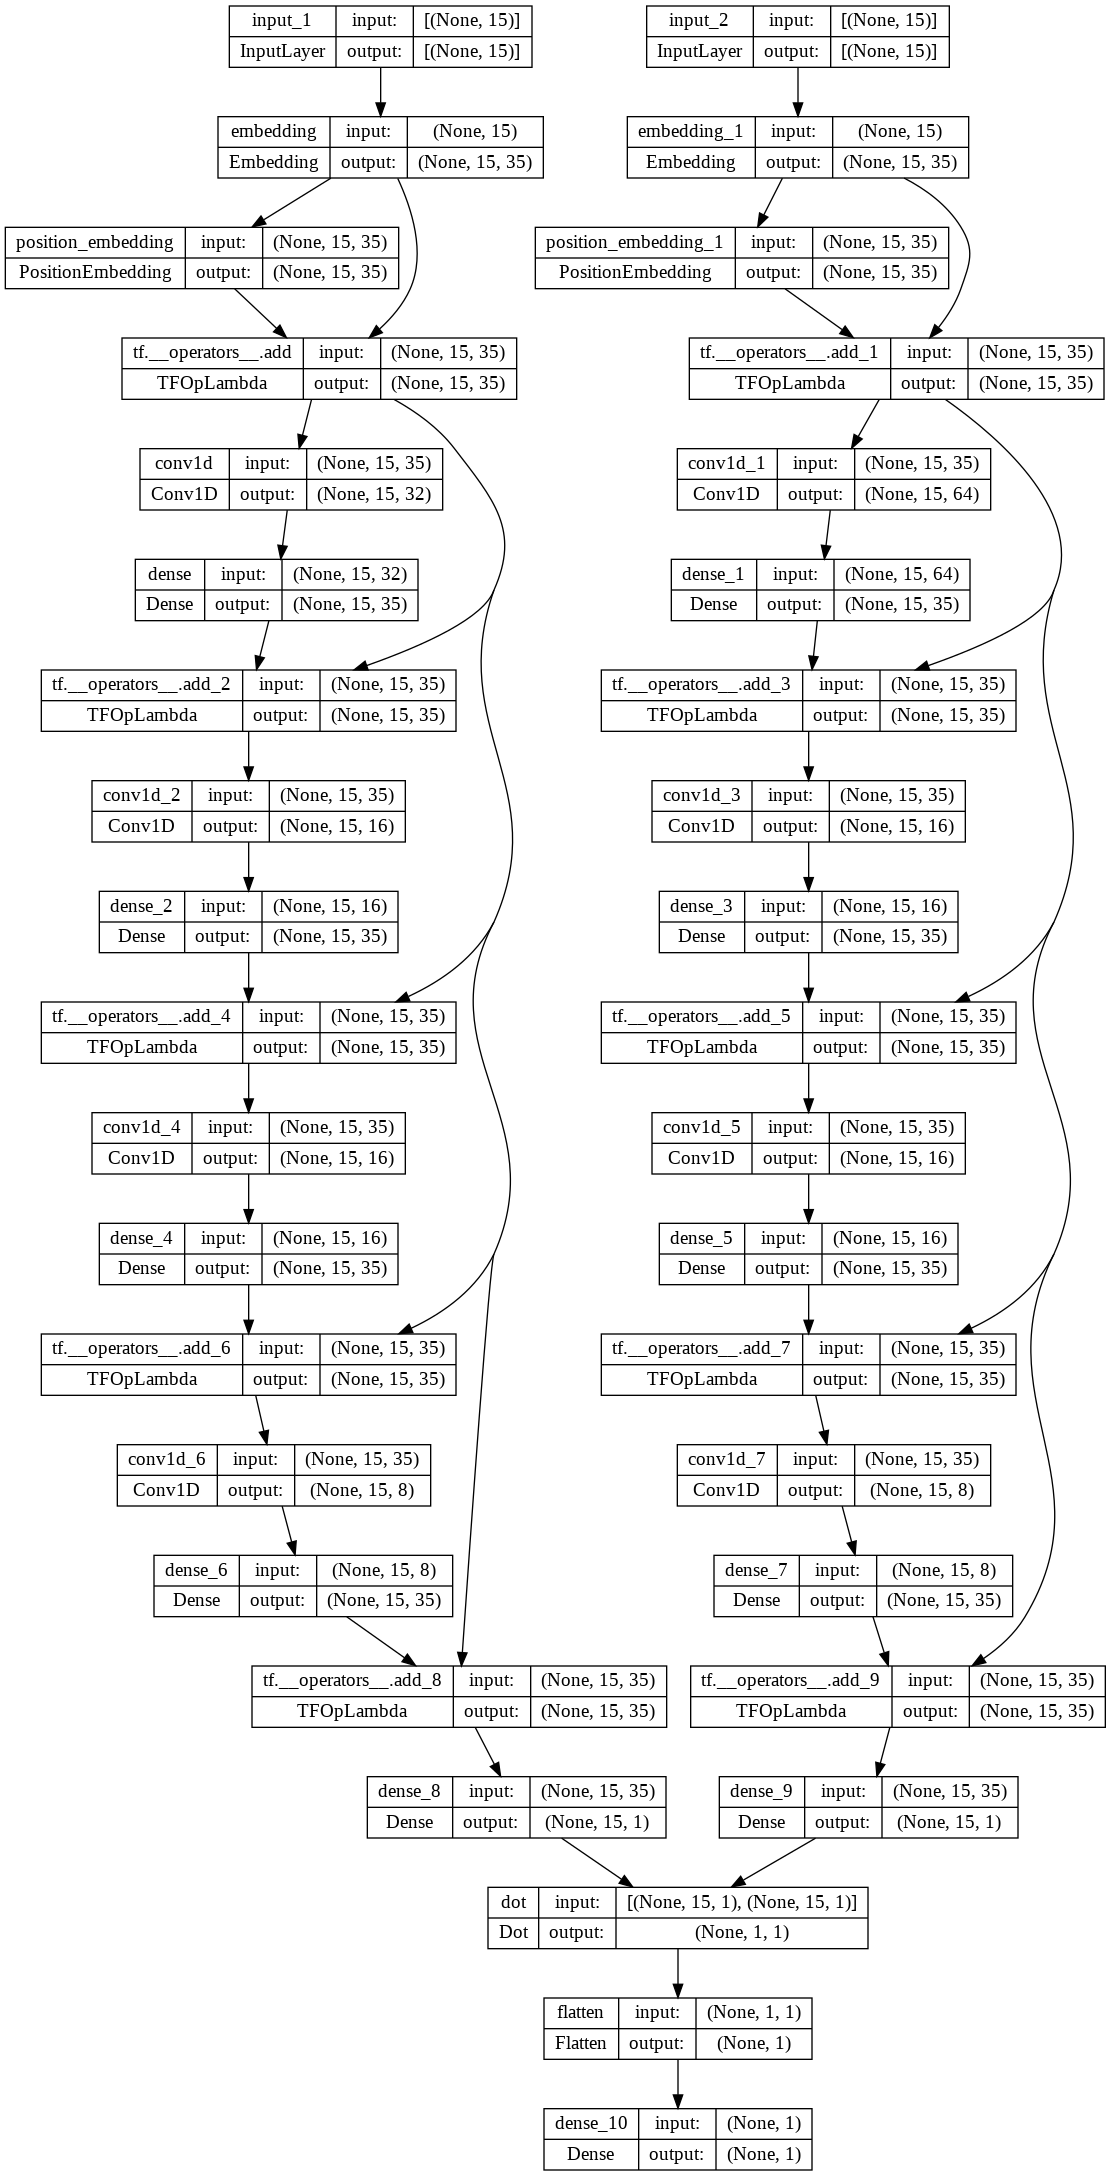

In [ ]:
tf.keras.utils.plot_model(siamese_net, show_shapes=True)

## Training

In [ ]:
from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau,
                                        CSVLogger, EarlyStopping)
from tensorflow.keras.optimizers import Adam


# checkpointer
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=75, mode='min'),
      ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                              patience=20, min_lr=0.001),
      ModelCheckpoint(filepath=models_folder + 'mixed_val_loss_different_weights_CNN.hdf5', 
                      monitor='val_loss',
                      verbose=1, 
                      save_best_only=True, 
                      mode='min',
                      restore_best_weights=True)
]

hist = siamese_net.fit(x = [train_data_names, train_data_nicknames],
                     y = train_targets,
                       validation_data=([validation_data_names, validation_data_nicknames], 
                                        validation_targets),
                       epochs = 100,
                       verbose = 1,
                       shuffle = True,
                       batch_size = 16,
                       callbacks=[keras_callbacks])

Epoch 1/100
472/472 [==============================] - ETA: 0s - loss: 0.5020
Epoch 1: val_loss improved from inf to 0.50419, saving model to ./models/mixed_val_loss_different_weights_CNN.hdf5
472/472 [==============================] - 26s 29ms/step - loss: 0.5020 - val_loss: 0.5042 - lr: 0.0500
Epoch 2/100
471/472 [============================>.] - ETA: 0s - loss: 0.4653
Epoch 2: val_loss improved from 0.50419 to 0.45226, saving model to ./models/mixed_val_loss_different_weights_CNN.hdf5
472/472 [==============================] - 6s 12ms/step - loss: 0.4652 - val_loss: 0.4523 - lr: 0.0500
Epoch 3/100
470/472 [============================>.] - ETA: 0s - loss: 0.4180
Epoch 3: val_loss improved from 0.45226 to 0.41447, saving model to ./models/mixed_val_loss_different_weights_CNN.hdf5
472/472 [==============================] - 6s 12ms/step - loss: 0.4173 - val_loss: 0.4145 - lr: 0.0500
Epoch 4/100
471/472 [============================>.] - ETA: 0s - loss: 0.4083
Epoch 4: val_loss improve

## Analyze results

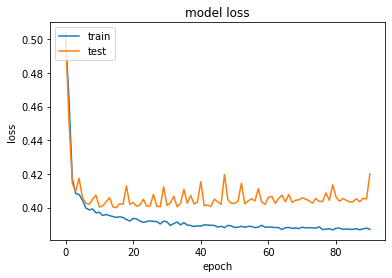

In [ ]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Predict

236/236 [==============================] - 2s 6ms/step
0.8142852949609157


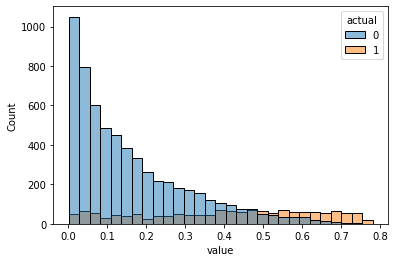

In [ ]:
from keras.models import load_model
import seaborn as sns
from sklearn import metrics

pd.options.display.float_format = '{:.2f}'.format

model = load_model(models_folder + 'mixed_val_loss_different_weights_CNN.hdf5', custom_objects={'PositionEmbedding': PositionEmbedding})

preds_train = pd.DataFrame(model.predict([train_data_names, train_data_nicknames]), columns = ['value'])
preds_train['actual'] = train_targets

fpr, tpr, thresholds = metrics.roc_curve(preds_train['actual'].values, 
                                         preds_train['value'].values)
print(metrics.auc(fpr, tpr))

sns.histplot(x = 'value', hue = 'actual', data = preds_train)

45/45 [==============================] - 1s 9ms/step
0.7972241918920242


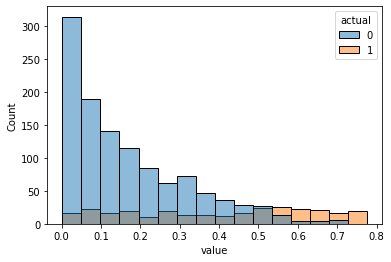

In [ ]:
from keras.models import load_model
import seaborn as sns
from sklearn import metrics

pd.options.display.float_format = '{:.2f}'.format

model = load_model(models_folder + 'mixed_val_loss_different_weights_CNN.hdf5', 
                   custom_objects={'PositionEmbedding': PositionEmbedding})

preds_val = pd.DataFrame(model.predict([validation_data_names, validation_data_nicknames]), 
                         columns = ['value'])
preds_val['actual'] = validation_targets

fpr, tpr, thresholds = metrics.roc_curve(preds_val['actual'].values, 
                                         preds_val['value'].values)
print(metrics.auc(fpr, tpr))

sns.histplot(x = 'value', hue = 'actual', data = preds_val)

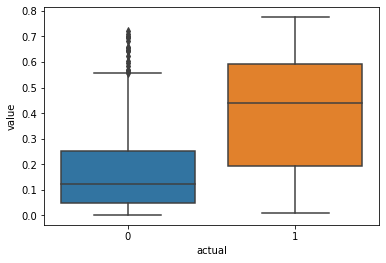

In [ ]:
import seaborn as sns

sns.boxplot(data = preds_val, y='value', x='actual')
# plt.ylim(0.39, 0.395)

# Analize examples

In [ ]:
def plot_oversampled_scores_distribution(df):
  from imblearn.over_sampling import RandomOverSampler
  import seaborn as sns
  
  # Looking at a balanced set
  ros = RandomOverSampler(random_state=1)
  X = df[['value']]
  y = df[['actual']]
  X_resampled, y_resampled = ros.fit_resample(X, y)

  balanced_df = pd.DataFrame(X_resampled, columns = ['value'])
  balanced_df['actual'] = y_resampled
  
  sns.histplot(x = 'value', hue = 'actual', data = balanced_df)
  plt.title("Predicted scores over different classes \n(after oversampling)")
  plt.show()


236/236 [==============================] - 2s 6ms/step


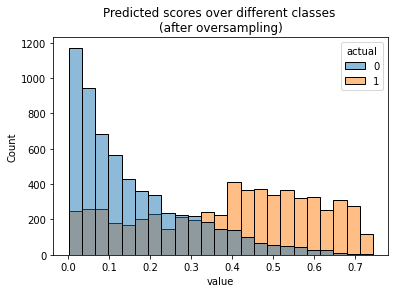

Sanity check: 1.0.


,value,actual,predicted_with_40_pct,name,nickname
0,0.197,0,False,theodore,cy
1,0.186,0,False,flora,belle
2,0.057,1,False,isabella,bel
3,0.014,0,False,jo,ara
4,0.043,0,False,clement,jessie


In [ ]:
model = load_model(models_folder + 'mixed_val_loss_different_weights_CNN.hdf5', custom_objects={'PositionEmbedding': PositionEmbedding})

preds_train = pd.DataFrame(model.predict([train_data_names, train_data_nicknames]), columns = ['value'])

preds_train['actual'] = train_targets
plot_oversampled_scores_distribution(preds_train)

preds_train['predicted_with_40_pct'] = (preds_train['value']>0.4)
preds_train['name'] = train_df['name'].values
preds_train['nickname'] = train_df['nickname'].values

print(f"Sanity check: {np.mean(preds_train['actual'].values == train_df['y'].values)}.")
preds_train.iloc[:5]


### Analyze Mistakes

In [ ]:
train_df[(train_df['nickname'] == 'allie') & (train_df['y'] == 1)]

,name,nickname,y
7291,alan,allie,1
6312,alison,allie,1
7465,alistair,allie,1
7054,almena,allie,1
7434,allisandra,allie,1
6133,alicia,allie,1
7243,alexandra,allie,1
7005,alice,allie,1
6352,aileen,allie,1
7448,alberta,allie,1


In [ ]:
train_df[(train_df['name'] == 'allie')]

,name,nickname,y
4817,allie,allie,0
293,allie,jem,0
1801,allie,NaN,0
3309,allie,con,0
6121,allie,ali,1


In [ ]:
train_df[(train_df['nickname'] == 'charlie') & (train_df['y'] == 1)]

,name,nickname,y
6539,charles,charlie,1
7528,charlene,charlie,1
7208,charlotte,charlie,1


In [ ]:
train_df[(train_df['name'] == 'charles') & (train_df['y'] == 1)]


,name,nickname,y
6242,charles,chuck,1
6902,charles,carl,1
6539,charles,charlie,1
7225,charles,chip,1
7258,charles,charley,1
6557,charles,chad,1
6868,charles,chas,1


In [ ]:
train_df[(train_df['name'] == 'margaret') & (train_df['y'] == 1)]


,name,nickname,y
7414,margaret,peggy,1
6800,margaret,peg,1
6715,margaret,margery,1
6491,margaret,maggie,1
6829,margaret,daisy,1
6346,margaret,meggie,1
6510,margaret,madge,1
6046,margaret,mae,1
6827,margaret,gretta,1
6307,margaret,maggy,1


In [ ]:
train_df[(train_df['nickname'] == 'ann')]


,name,nickname,y
4783,katherine,ann,0
260,katherine,ann,0
2389,wilfred,ann,0
1261,lenora,ann,0
1889,gerald,ann,0
6447,roxanne,ann,1
4622,patrick,ann,0
1840,alicia,ann,0
4636,joseph,ann,0
2473,mick,ann,0


In [ ]:
FP_mask = (preds_train['actual'] == 0) & (preds_train['predicted_with_40_pct'].astype(int) == 1)
FN_mask = (preds_train['actual'] == 1) & (preds_train['predicted_with_40_pct'].astype(int) == 0)
TN_mask = (preds_train['actual'] == 0) & (preds_train['predicted_with_40_pct'].astype(int) == 0)
TP_mask = (preds_train['actual'] == 1) & (preds_train['predicted_with_40_pct'].astype(int) == 1)
preds_train['closest_to_30_pct'] = np.abs(preds_train['value'] - 0.3)
preds_train['closest_to_40_pct'] = np.abs(preds_train['value'] - 0.4)
preds_train['closest_to_50_pct'] = np.abs(preds_train['value'] - 0.5)

print('FP:\n', FP_mask.value_counts())
print('FN:\n', FN_mask.value_counts())
print('')
print("10 Highest FP cases:")
print(preds_train[FP_mask].sort_values(['value'],ascending=False).\
  filter(items = ['name', 'nickname', 'value', 'actual'])[:11])
print("10 Lowest FN cases:")
print(preds_train[FN_mask].sort_values(['value'],ascending=True).\
  filter(items = ['name', 'nickname', 'value', 'actual'])[:10])
print("10 Highest TP cases:")
print(preds_train[TP_mask].sort_values(['value'],ascending=False).\
  filter(items = ['name', 'nickname', 'value', 'actual'])[:10])
print("10 Lowest TN cases:")
print(preds_train[TN_mask].sort_values(['value'],ascending=True).\
  filter(items = ['name', 'nickname', 'value', 'actual'])[:10])


FP:
 False    7062
True      478
dtype: int64
FN:
 False    6862
True      678
dtype: int64

10 Highest FP cases:
           name nickname  value  actual
5173       mary    margy  0.721       0
6948     martha   mattie  0.720       0
6910     martha    manny  0.706       0
3033   ignatius    netta  0.701       0
2113     mervin     maud  0.686       0
939       allie    allie  0.685       0
6358  christine      ann  0.683       0
2475    charles  charlie  0.682       0
1387       mike    matty  0.682       0
3858   margaret   maggie  0.675       0
1000   christie   cassie  0.674       0
10 Lowest FN cases:
           name nickname  value  actual
2346    alfreda   frieda  0.007       1
2156     amanda    manda  0.009       1
5632    adeline     lena  0.009       1
4599    lucille    cille  0.010       1
2628     amanda    mandy  0.010       1
6610    marilla    rilla  0.011       1
1941  broderick     rick  0.011       1
1683  broderick    ricky  0.011       1
3356    rosalyn    linda  

In [ ]:
print('10 closest names to the boundary of 0.30:')
print(preds_train.sort_values(['closest_to_30_pct'],ascending=True).\
  filter(items = ['name', 'nickname', 'value', 'actual'])[:10])
print('10 closest names to the boundary of 0.40:')
print(preds_train.sort_values(['closest_to_40_pct'],ascending=True).\
  filter(items = ['name', 'nickname', 'value', 'actual'])[:10])
print('10 closest names to the boundary of 0.50:')
print(preds_train.sort_values(['closest_to_50_pct'],ascending=True).\
  filter(items = ['name', 'nickname', 'value', 'actual'])[:10])


10 closest names to the boundary of 0.30:
           name nickname  value  actual
4587   gertrude   fannie   0.30       0
1321  catherine     rudy   0.30       0
2350    lillian     maxy   0.30       0
3538      susan     susy   0.30       1
2786   charlene    randy   0.30       0
518     adeline    chris   0.30       0
2979        ray   cammie   0.30       0
2878   prudence     prue   0.30       1
6732      calum      rae   0.30       0
6196   michelle   berney   0.30       0
10 closest names to the boundary of 0.40:
           name nickname  value  actual
7538      susan    suzie   0.40       1
44     sullivan     jule   0.40       0
478      amelia      lon   0.40       0
3453      alice    allie   0.40       1
6236      nancy      NaN   0.40       1
1106   victoria    ricky   0.40       0
2833       dick      dan   0.40       0
122        jane     vern   0.40       0
4917  nathaniel      nat   0.40       1
7359      agnes    nessa   0.40       1
10 closest names to the boundary of 

# Refine

236/236 [==============================] - 9s 7ms/step
0.8142852949609157


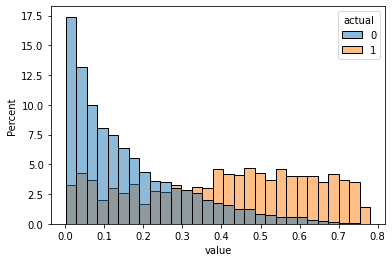

In [ ]:
from keras.models import load_model
import seaborn as sns
from sklearn import metrics

pd.options.display.float_format = '{:.2f}'.format

model = load_model(models_folder + 'mixed_val_loss_different_weights_CNN.hdf5', custom_objects={'PositionEmbedding': PositionEmbedding})

preds_train = pd.DataFrame(model.predict([train_data_names, train_data_nicknames]), columns = ['value'])
preds_train['actual'] = train_targets

fpr, tpr, thresholds = metrics.roc_curve(preds_train['actual'].values, 
                                         preds_train['value'].values)
print(metrics.auc(fpr, tpr))

sns.histplot(x = 'value', hue = 'actual', data = preds_train, stat="percent", common_norm=False)

In [ ]:
# preds_train = pd.DataFrame(model.predict([train_data_names, train_data_nicknames]), columns = ['value'])
train_df_processed = train_df.copy()
train_df_processed['predicted'] = preds_train.values
P_avg = pd.DataFrame(train_df[train_df['y']==1].groupby('name')['predicted'].mean())
N_avg = pd.DataFrame(train_df[train_df['y']==0].groupby('name')['predicted'].mean())
P_avg.rename({'predicted':'P_avg'},axis=1, inplace=True)
N_avg.rename({'predicted':'N_avg'},axis=1, inplace=True)
P_avg.reset_index(drop=False,inplace=True)
N_avg.reset_index(drop=False,inplace=True)
train_df_processed = train_df_processed.merge(P_avg,
                                              on='name',
                                              how='left',
                                              indicator = False)
train_df_processed = train_df_processed.merge(N_avg,
                                              on='name',
                                              how='left',
                                              indicator = False)

def filter_close_examples(df, tolerance=0.1):
  import numpy as np
  mask = (np.abs(df['P_avg']-df['N_avg'])<=tolerance)
  return df[mask], mask

masked_data, _ = filter_close_examples(train_df_processed)
masked_data['predicted_with_40_pct'] = (masked_data['predicted']>0.4)

print(pd.crosstab(masked_data['y'],
            masked_data['predicted_with_40_pct'],
            normalize='index').round(3))
masked_data


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


predicted_with_40_pct  False  True
y                                 
0                       0.93  0.07
1                       0.91  0.09


,name,nickname,y,predicted,P_avg,N_avg,predicted_with_40_pct
2,isabella,bel,1,0.05,0.12,0.12,False
5,vanessa,eddy,0,0.03,0.23,0.22,False
14,derrick,clara,0,0.08,0.17,0.17,False
18,armena,trina,0,0.21,0.05,0.09,False
28,isabella,delia,0,0.06,0.12,0.12,False
...,...,...,...,...,...,...,...
7516,isabel,gabby,0,0.13,0.17,0.18,False
7517,paula,camp,0,0.11,0.06,0.11,False
7531,emmanuel,manny,1,0.02,0.02,0.03,False
7532,alexander,court,0,0.44,0.21,0.18,True


The second training is going to give the network harder and harder cases, so I first fix the boundary to be 0.4, and then start to aproach it with decreasing tolerance.

In [ ]:
from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau,
                                        CSVLogger, EarlyStopping)
from tensorflow.keras.optimizers import Adam


# checkpointer
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=75, mode='min'),
      ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                              patience=20, min_lr=0.001),
      ModelCheckpoint(filepath=models_folder + 'mixed_val_loss_different_weights_CNN.hdf5', 
                      monitor='val_loss',
                      verbose=1, 
                      save_best_only=True, 
                      mode='min',
                      restore_best_weights=True)
]


In [ ]:
for tol in [0.5, 0.4, 0.2, 0.1,0.05]:
  print('\n\n\n')
  print('*'*25)
  print(f'Stating to train using a {tol} tolerance.')
  print('*'*25)

  _, mask = filter_close_examples(train_df_processed, tolerance=tol)

  masked_names = train_data_names[mask.values]
  masked_nicknames =train_data_nicknames[mask.values]
  masked_targets = train_targets[mask.values]

  model.fit(x = [masked_names, masked_nicknames],
                     y = masked_targets,
            validation_data=([validation_data_names, validation_data_nicknames], 
                                validation_targets),
            epochs = 7,
            verbose = 1,
            shuffle = True,
            batch_size = 16,
            callbacks=[keras_callbacks])







*************************
Stating to train using a 0.5 tolerance.
*************************
Epoch 1/7
434/436 [============================>.] - ETA: 0s - loss: 0.4103
Epoch 1: val_loss did not improve from 0.40223
436/436 [==============================] - 6s 13ms/step - loss: 0.4099 - val_loss: 0.4084 - lr: 0.0500
Epoch 2/7
433/436 [============================>.] - ETA: 0s - loss: 0.4080
Epoch 2: val_loss improved from 0.40223 to 0.40054, saving model to ./models/mixed_val_loss_different_weights_CNN.hdf5
436/436 [==============================] - 6s 13ms/step - loss: 0.4094 - val_loss: 0.4005 - lr: 0.0500
Epoch 3/7
435/436 [============================>.] - ETA: 0s - loss: 0.4068
Epoch 3: val_loss did not improve from 0.40054
436/436 [==============================] - 7s 15ms/step - loss: 0.4071 - val_loss: 0.4019 - lr: 0.0500
Epoch 4/7
433/436 [============================>.] - ETA: 0s - loss: 0.4071
Epoch 4: val_loss did not improve from 0.40054
436/436 [======================

In our case, additional training have not led to better performence. One possible reason for that is our overall small data to begin with. Given new data, maybe we could have escaped the local minimum by expanding our model. 